In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import cppimport
cppimport.settings['release_mode'] = True
cppimport.settings['force_rebuild'] = True
glstudy = cppimport.imp_from_filepath("glstudy.cpp")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [25]:
def check_acc(beta, L, v, l1, l2):
    return beta - (v /(L + l2 + l1 / np.sqrt(np.sum(beta**2))))

In [35]:
def bench(ps, configs):
    algs_dict = {
        'Newton': glstudy.newton_solver,
        'Newton-ABS': glstudy.newton_abs_solver,
        'ISTA': glstudy.ista_solver,
        'FISTA': glstudy.fista_solver,
        'FISTA-ADA': glstudy.fista_adares_solver,
    }

    index_names = list(algs_dict.keys())
    if 'skip' in configs:
        index_names = [ind for ind in index_names if ind not in configs['skip']]

    seed = configs['seed']
    max_eval = configs['max_eval']
    l1 = configs['l1']
    l2 = configs['l2']
    newton_tol = configs['newton_tol']
    fista_tol = configs['fista_tol']
    max_iters = configs['max_iters']
    
    tols_dict = {
        'Newton': newton_tol,
        'Newton-ABS': newton_tol,
        'ISTA': fista_tol,
        'FISTA': fista_tol,
        'FISTA-ADA': fista_tol,
    }

    numbers_dict = {
        'Newton': 1000,     
        'Newton-ABS': 1000,
        'ISTA': 10,
        'FISTA': 10,
        'FISTA-ADA': 10,
    }

    n_ps = len(ps)
    n_algs = len(index_names)
    times = np.zeros((n_algs, n_ps))
    iters = np.zeros((n_algs, n_ps))
    accs = np.zeros((n_algs, n_ps))
    data = []
    
    for i, p in enumerate(ps):
        np.random.seed((seed + 100*i) % 1000007)
        
        # generate data
        L_zero_prop = configs['L_zero_prop']
        L_small_prop = configs['L_small_prop']
        L = np.concatenate(
            [np.zeros(int(p * L_zero_prop)),
             np.random.uniform(1e-14, 1e-8, int(p * L_small_prop))]
        )
        L = np.concatenate(
            [L, np.random.uniform(0.8, max_eval, p - len(L))]
        )
        v = np.random.normal(0, 1, size=(p,)) * np.sqrt(L)

        # save data
        data.append((L, v))

        def _bench(ind):
            tm = timeit.repeat(
                lambda: algs_dict[ind](L, v, l1, l2, tols_dict[ind], max_iters), 
                repeat=1, 
                number=numbers_dict[ind],
            )[0] / numbers_dict[ind]
            return tm

        # benchmark
        curr_times = [_bench(ind) for ind in index_names]

        # call for outputs
        curr_outs = [
            algs_dict[ind](L, v, l1, l2, tols_dict[ind], max_iters)
            for ind in index_names
        ]
        
        # save output
        times[:, i] = curr_times
        iters[:, i] = [out['iters'] for out in curr_outs]
        accs[:, i] =[
            np.max(np.abs(check_acc(out['beta'], L, v, l1, l2)))
            for out in curr_outs
        ]

    return ps, configs, data, index_names, times, iters, accs


In [36]:
def bench_assess(bench_out, filename=None):
    ps, _, _, index_names, times, iters, accs = bench_out

    best_pos = index_names.index('Newton-ABS')
    rel_times = times / times[best_pos][None]
    types = [times, rel_times, iters, accs]
    type_names = ["Time", "Relative Time", "Iterations", "Accuracy"]
    ylabels = ["Time (s)", "Relative Time to Newton-ABS", "Iterations", "$\max_i |\hat{\\beta}_i - \\beta^{\star}_i |$"]

    markers = ['.', '*', 'v', 'x', '1']
    linestyles = ['-.'] * len(markers)

    _, axes = plt.subplots(2, 2, figsize=(8, 8))
    for row in range(2):
        for col in range(2):
            j = 2 * row + col
            ax = axes[row, col]
            vals = types[j]
            for i, vals_alg in enumerate(vals):
                ax.plot(ps, vals_alg, marker=markers[i], label=index_names[i], linestyle=linestyles[i])
            ax.legend()
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_title(f"{type_names[j]} Comparison")
            ax.set_xlabel("Number of features")
            ax.set_ylabel(ylabels[j])

    plt.tight_layout()
    if not (filename is None):
        plt.savefig(f"figures/pgd_newton_{filename}.pdf", bbox_inches='tight')
    plt.show()

    return bench_out

In [37]:
ps = np.array([10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 750, 1000, 2500, 5000, 7500, 10000])

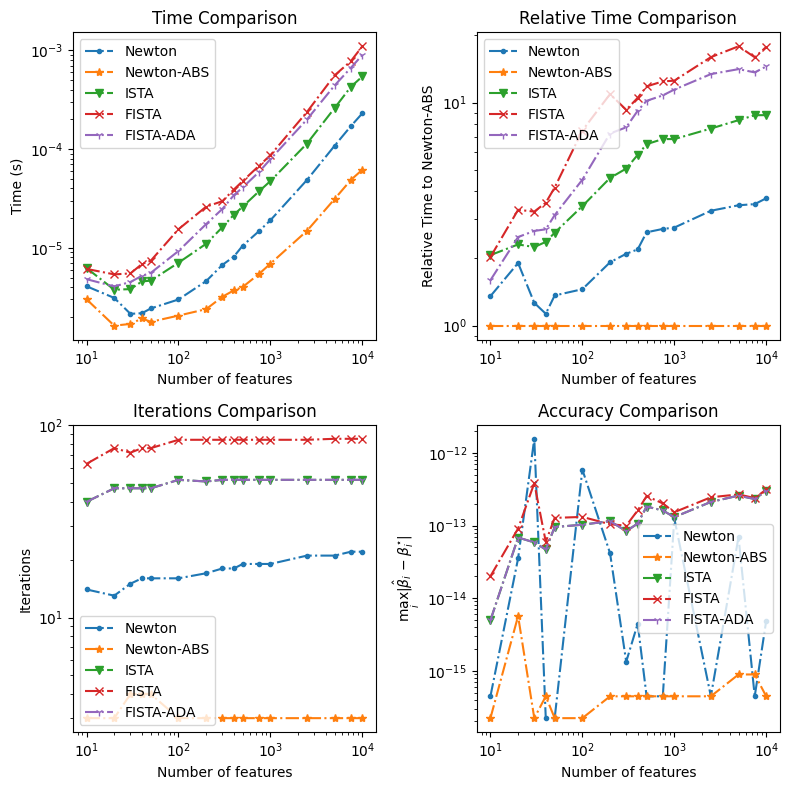

In [38]:
configs = {
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.0,
}
bench_pd = bench_assess(bench(ps, configs), filename='pd')

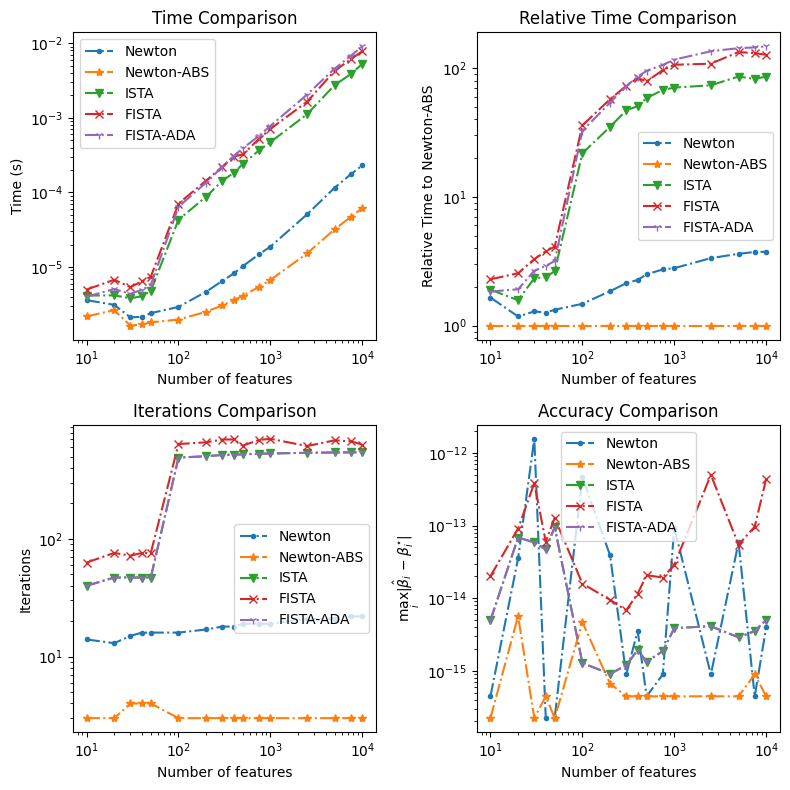

In [39]:
configs = {
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.01,
}
bench_almost_psd = bench_assess(bench(ps, configs), filename='almost_psd')

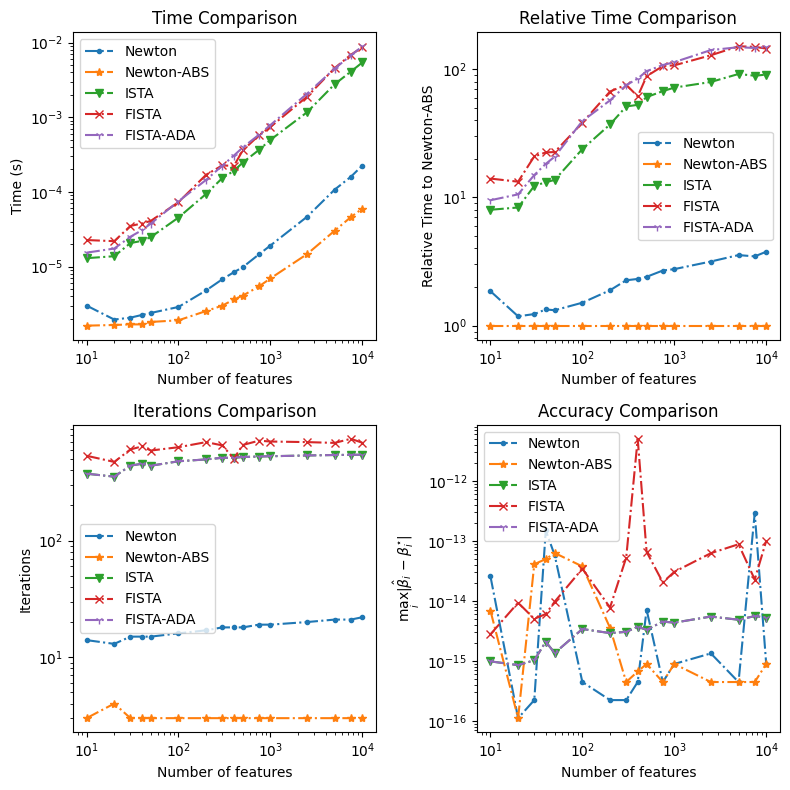

In [40]:
configs = {
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.1,
    'L_small_prop': 0.2,
}
bench_very_psd = bench_assess(bench(ps, configs), filename='very_psd')

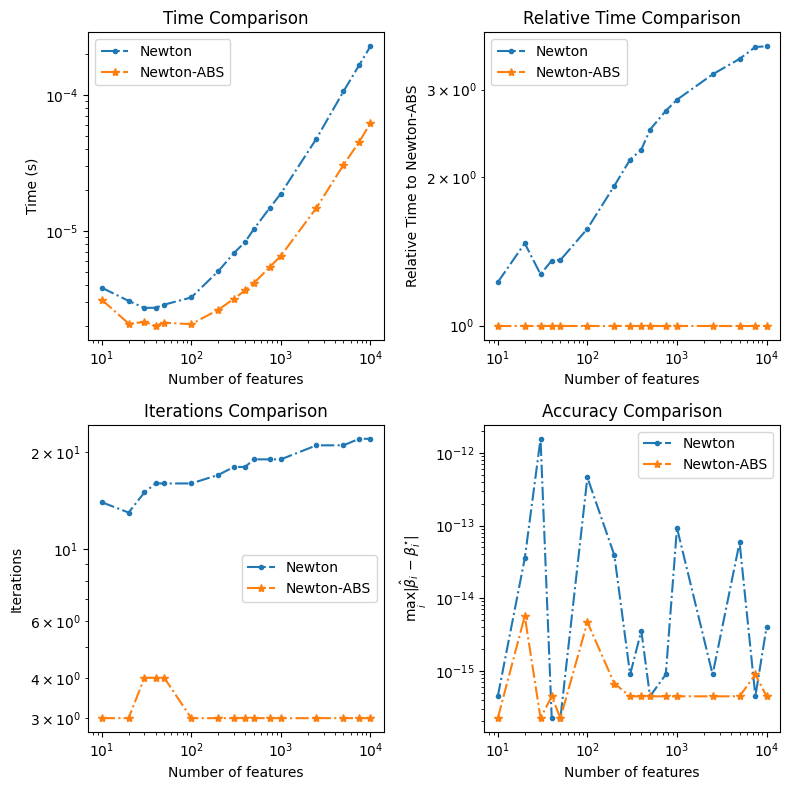

In [41]:
configs = {
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.01,
    'skip': ['ISTA', 'FISTA', 'FISTA-ADA']
}
bench_out = bench_assess(bench(ps, configs))